## Trabalho Prático 2 - Planejamento e Navegação

Utilizando a estratégia de planejamento de caminhos Roadmap, deve-se utilizar um robô Holonômico.

As carcterísticas de um robô holonômico são: 
- Possuem um número de velocidades atuáveis 

#### Instalando pacotes não habituais utilizados no código

In [28]:
#pip install coppeliasim-zmqremoteapi-client

### Importando as bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import networkx as nx
from coppeliasim_zmqremoteapi_client import *
import random

### Remote API functions (Python)

Criação do cliente para conexão com a api remota

Link para repositório da SimZMQRemoteApi: https://github.com/CoppeliaRobotics/zmqRemoteApi/tree/master/clients/python

In [2]:
# create a client to connect to zmqRemoteApi server:
# (creation arguments can specify different host/port,
# defaults are host='localhost', port=23000)
client = RemoteAPIClient()

# get a remote object:
sim = client.require('sim')

# call API function fo test:
robotino = sim.getObject('/robotino')
print("Printando o robotininho: " + str(robotino))

Printando o robotininho: 15


### Funções auxiliares

In [3]:
# Função para rotacionar em torno do eixo z
def Rz(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])

def get_object_position(sim, object_name):
    return sim.getObjectPosition(sim.getObject(object_name), -1)

def get_object_orientation(sim, object_name):
    return sim.getObjectOrientation(sim.getObject(object_name), -1)

#### Carregando imagem do mapa

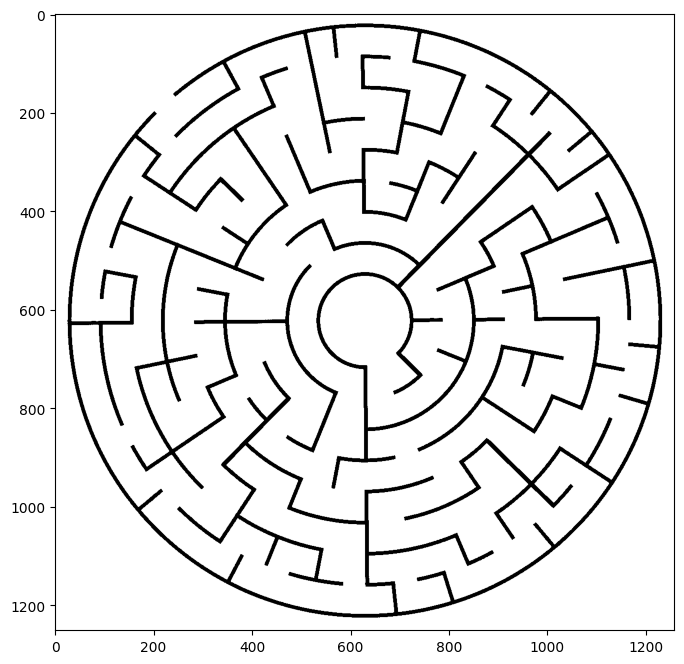

In [27]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Invertendo os valores para visualização (Branco - 0, Preto - 1)
img = 1 - mpimg.imread('circular_maze.png')

# Apenas para garantir que só teremos esses dois valores
threshold = 0.5
img[img > threshold] = 1
img[img<= threshold] = 0

ax.imshow(img, cmap='Greys', origin='upper')

#### Criando o grid com as células binarizadas

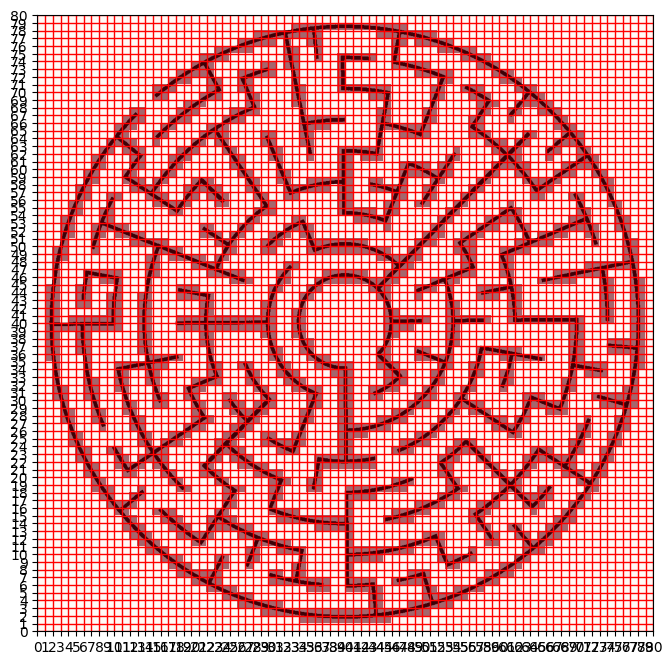

In [30]:
# Dimensões do mapa informado em metros (X, Y)
#map_dims = np.array([40, 40]) # Cave 
map_dims = np.array([80, 80])  # Maze Circle

# Escala Pixel/Metro
sy, sx = img.shape / map_dims

# Tamanho da célula do nosso Grid (em metros)
# cell_size = 2 # Cave
cell_size = 1 # Maze Circle

rows, cols = (map_dims / cell_size).astype(int)
grid = np.zeros((rows, cols))

# Preenchendo o Grid
# Cada célula recebe o somatório dos valores dos Pixels
for r in range(rows):
    for c in range(cols):
        
        xi = int(c*cell_size*sx)
        xf = int(xi + cell_size*sx)
        
        yi = int(r*cell_size*sy)
        yf = int(yi + cell_size*sy)
                      
        grid[r, c] = np.sum(img[yi:yf,xi:xf])
        
# Binarizando as células como Ocupadas (1) ou Não-ocupadas (0)       
grid[grid > threshold] = 1
grid[grid<= threshold] = 0        

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Plotando Mapa e Células
obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

# Plotando as linhas do grid para facilitar a visualização
ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

### Criando o Grafo para o Grid feito

Start: (0, 0)
End: (79, 79)


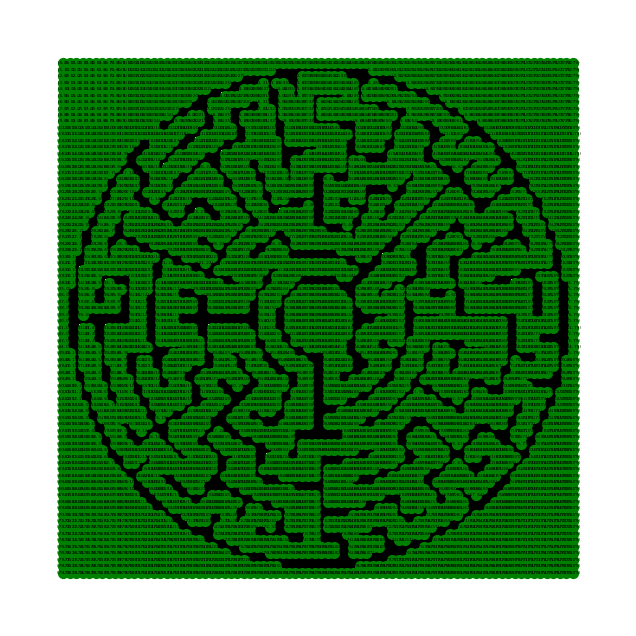

In [31]:
# Criando vértices em todas as células
G = nx.grid_2d_graph(rows, cols) 

# Removendo células que estão em células marcas com obstáculos
for r in range(rows):
    for c in range(cols):
        if grid[r][c] == 1:  
            G.remove_node((r,c))


fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Grid
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))

ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

# Os vértices serão plotados no centro da célula  
pos = {node:(node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2) for node in G.nodes()}
nx.draw(G, pos, font_size=3, with_labels=True, node_size=50, node_color="g", ax=ax)

# Vértices de início e fim
start = (0,0)
end = (rows-1, cols-1)
print("Start:", start)
print("End:", end)

#### Determinando o melhor caminho

End node: (13, 76)
Path: [(1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6), (11, 7), (11, 8), (11, 9), (11, 10), (11, 11), (11, 12), (11, 13), (11, 14), (12, 14), (13, 14), (14, 14), (15, 14), (16, 14), (17, 14), (17, 15), (17, 16), (16, 16), (16, 17), (15, 17), (15, 18), (14, 18), (14, 19), (14, 20), (13, 20), (13, 21), (12, 21), (12, 22), (11, 22), (11, 23), (11, 24), (10, 24), (9, 24), (8, 24), (7, 24), (6, 24), (6, 25), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (6, 31), (7, 31), (8, 31), (9, 31), (10, 31), (11, 31), (12, 31), (13, 31), (14, 31), (14, 30), (14, 29), (14, 28), (15, 28), (16, 28), (17, 28), (18, 28), (19, 28), (20, 28), (20, 29), (21, 29), (22, 29), (22, 30), (22, 31), (23, 31), (24, 31), (25, 31), (26, 31), (26, 30), (26, 29), (27, 29), (27, 28), (28, 28), (29, 28), (30, 28), (31, 28), (31, 29), (31, 30), (31, 31), (31, 32), (31, 33), (31, 34), (32, 34), (33, 34), (33, 33

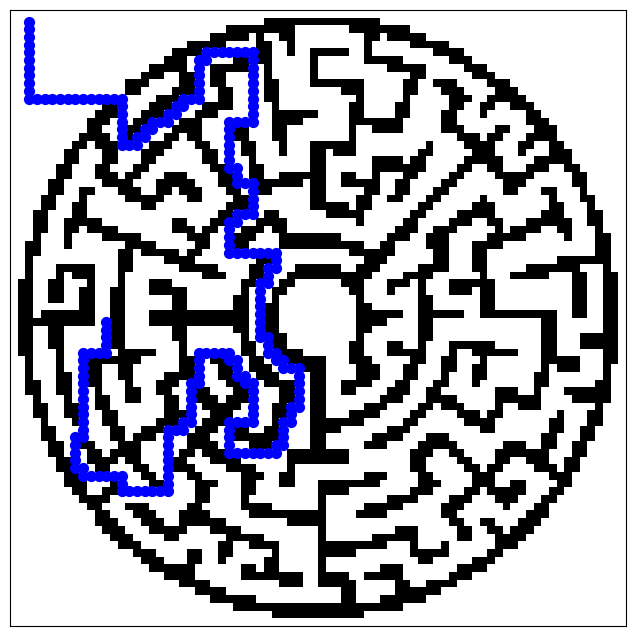

In [32]:
# Cave
start_node =  (1, 2)
# gerar um valor aleatório para o end_node que esteja dentro do grid e não seja um obstáculo
if grid[r][c] != 1: 
    end_node = (random.randint(0, rows-1), random.randint(0, cols-1))
print("End node:", end_node)

end_node = (18, 17)

# se o nó final for um obstáculo, gerar um novo nó final
while grid[end_node[0]][end_node[1]] == 1:
    end_node = (random.randint(0, rows-1), random.randint(0, cols-1))

#end_node = (17, 18) # Goal 1

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Mapa
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))

# Caminho
path = nx.shortest_path(G, source=start_node, target=end_node)
nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=50, node_color='b')

print("Path:", path)
#prntar o número de posições no path
print("Path length:", len(path))

#### Convertendo para os referenciais da cena

Coppelia Path length: 224
Coppelia Path: [[-18.25  18.75]
 [-18.25  18.25]
 [-18.25  17.75]
 [-18.25  17.25]
 [-18.25  16.75]
 [-18.25  16.25]
 [-18.25  15.75]
 [-18.25  15.25]
 [-18.25  14.75]
 [-18.25  14.25]
 [-18.25  13.75]
 [-17.75  13.75]
 [-17.25  13.75]
 [-16.75  13.75]
 [-16.25  13.75]
 [-15.75  13.75]
 [-15.25  13.75]
 [-14.75  13.75]
 [-14.25  13.75]
 [-13.75  13.75]
 [-13.25  13.75]
 [-12.75  13.75]
 [-12.25  13.75]
 [-12.25  13.25]
 [-12.25  12.75]
 [-12.25  12.25]
 [-12.25  11.75]
 [-12.25  11.25]
 [-12.25  10.75]
 [-11.75  10.75]
 [-11.25  10.75]
 [-11.25  11.25]
 [-10.75  11.25]
 [-10.75  11.75]
 [-10.25  11.75]
 [-10.25  12.25]
 [ -9.75  12.25]
 [ -9.25  12.25]
 [ -9.25  12.75]
 [ -8.75  12.75]
 [ -8.75  13.25]
 [ -8.25  13.25]
 [ -8.25  13.75]
 [ -7.75  13.75]
 [ -7.25  13.75]
 [ -7.25  14.25]
 [ -7.25  14.75]
 [ -7.25  15.25]
 [ -7.25  15.75]
 [ -7.25  16.25]
 [ -6.75  16.25]
 [ -6.75  16.75]
 [ -6.25  16.75]
 [ -5.75  16.75]
 [ -5.25  16.75]
 [ -4.75  16.75]
 [ -4.2

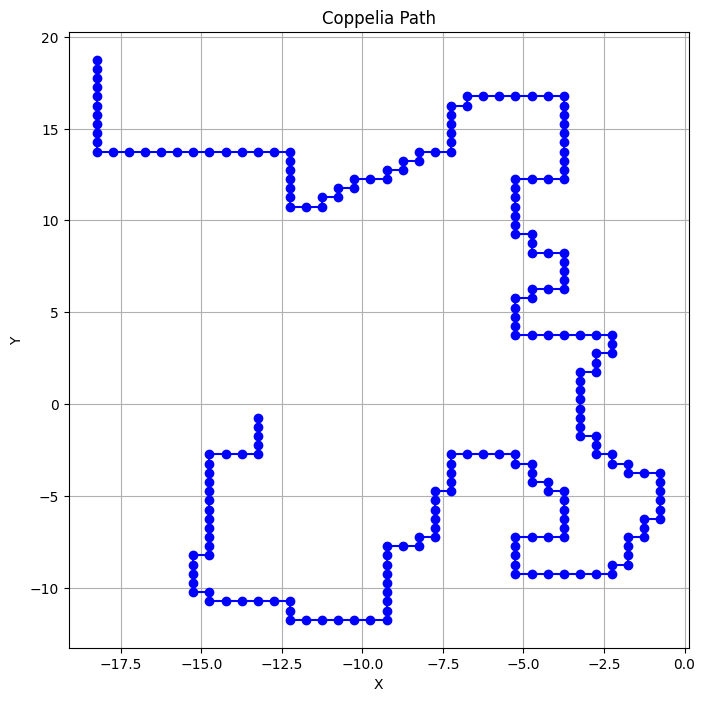

In [35]:
# Convertendo para os referenciais da cena
path = np.asarray(path) # Convertendo para array numpy
#print("Path cru: ",path)
path[:, [1, 0]] = path[:, [0, 1]] # invertendo os eixos porque no mapa utilizamos os nós invertidos.
path = path * cell_size + cell_size/2 # Convertendo para metros e adicionando o deslocamento para o centro da célula


#coppeliaPath = [20, 20] - path # Cave
coppeliaPath = [40, 40] - path # Maze Circle
for i in range(len(coppeliaPath)):
    coppeliaPath[i, 0] = (coppeliaPath[i, 0] * (-1))/2
    coppeliaPath[i, 1] = (coppeliaPath[i, 1])/2

print("Coppelia Path length:", len(coppeliaPath))
print("Coppelia Path:", coppeliaPath)

#printar a última posição do array de path
print("Goal -> ", path[-1])
print("Goal Coppelia -> ", coppeliaPath[-1])

# Plotando o caminho do coppelia
plt.figure(figsize=(8, 8))
plt.plot(coppeliaPath[:, 0], coppeliaPath[:, 1], marker='o', color='b')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Coppelia Path')
plt.grid(True)
plt.show() 
    

## Movimentação do robô

In [36]:
# Conectando-se ao CoppeliaSim
# Run a simulation in asynchronous mode:
clientID = sim.startSimulation()


if clientID != -1:
    print("Connected to remote API server")

    # Get the robot's handle
    robotino = sim.getObjectHandle('/robotino')

    # Get the robot's wheels
    wheel1 = sim.getObjectHandle('wheel0_joint')
    wheel2 = sim.getObjectHandle('wheel1_joint')
    wheel3 = sim.getObjectHandle('wheel2_joint')

    # Retirado da aula 07 de navegação 
    # Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros
               
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])
                       
    ganho = np.array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]]) # Ganho do controlador

    coppeliaPath = np.column_stack((coppeliaPath, np.zeros(len(coppeliaPath))))

for i in range(len(coppeliaPath)):
    # Posição do Robotino
    print("Goal: ", coppeliaPath[-1])

    while True:
        # Posição inicial do Robotino em cena
        robotinoPos = get_object_position(sim, '/robotino')  #start
        robotinoOri = get_object_orientation(sim, '/robotino')
        
        q_robot = np.array([robotinoPos[0], robotinoPos[1], robotinoOri[2]])

        # Calcule o erro entre a posição atual e o próximo ponto do caminho
        error = coppeliaPath[i] - q_robot
        errorNorm = np.linalg.norm(error[:2])

        print("Coppelia: ", q_robot)

        if errorNorm < 0.05:
            print("Goal reached")
            break

        # Calcule o vetor de controle usando o ganho e o erro
        qdot = ganho @ error

        # Calculando a velocidade linear e angular
        Minv = np.linalg.inv(Rz(q_robot[2]) @ Mdir)
        u = Minv @ qdot

        # Enviando velocidades para as rodas
        sim.setJointTargetVelocity(wheel1, 10 * u[0])
        sim.setJointTargetVelocity(wheel2, 10 * u[1])
        sim.setJointTargetVelocity(wheel3, 10 * u[2])

        # Atualizando a posição e orientação do robô
        robotinoPos = sim.getObjectPosition(robotino, -1)
        robotinoOri = sim.getObjectOrientation(robotino, -1)

    # Parando as rodas
    sim.setJointTargetVelocity(wheel1, 0)
    sim.setJointTargetVelocity(wheel2, 0)
    sim.setJointTargetVelocity(wheel3, 0)

pos = sim.getObjectPosition(robotino, -1)
print(pos)

# Stop the simulation:
sim.stopSimulation()

Connected to remote API server
Goal:  [ 7.5 -8.5  0. ]
Coppelia:  [-8.90243923  8.9450971   0.08591235]
Coppelia:  [-8.59274529  8.79836304  0.3302007 ]
Coppelia:  [-8.43243902  8.7438333   0.52446512]
Coppelia:  [-8.19617589  8.69368611  0.74084799]
Coppelia:  [-8.04628791  8.67480606  0.88527952]
Coppelia:  [-7.94830666  8.656742    0.94097355]
Coppelia:  [-7.85107179  8.63157984  0.92884601]
Coppelia:  [-7.78342385  8.6076556   0.88183668]
Coppelia:  [-7.72894096  8.58590893  0.72892375]
Coppelia:  [-7.69303745  8.5664123   0.61279662]
Coppelia:  [-7.67243947  8.55692481  0.54167008]
Coppelia:  [-7.64525836  8.54570171  0.44972223]
Coppelia:  [-7.62293425  8.53656102  0.39609105]
Coppelia:  [-7.59202007  8.52452556  0.26520324]
Coppelia:  [-7.57135393  8.51570252  0.19320916]
Coppelia:  [-7.55175977  8.50965248  0.14480569]
Coppelia:  [-7.54299854  8.5075385   0.11749627]
Goal reached
Goal:  [ 7.5 -8.5  0. ]
Coppelia:  [-7.53905753  8.50640079  0.09914687]
Coppelia:  [-7.53862273  8